In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 1e-3
EPS = 1e-10
ALPHA = 0.05
T=5
device = 'cuda:0'

In [2]:
def train_instance(model, optimizer, pyg_data, distances, n_ants):
    model.train()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    phe_mat, heu_mat = model.reshape(pyg_data, phe_vec) + EPS, model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO(
        n_ants=n_ants,
        pheromone=phe_mat,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    k_sparse = pyg_data.num_edges // pyg_data.num_nodes
    entropy_loss = ALPHA * (-torch.sum(Categorical(phe_mat).entropy()) / k_sparse)
    # print(reinforce_loss.item(), entropy_loss.item())
    loss = reinforce_loss + entropy_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    phe_vec, heu_vec = model(pyg_data, require_phe=True, require_heu=True)
    phe_mat, heu_mat = model.reshape(pyg_data, phe_vec) + EPS, model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        pheromone=phe_mat,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        instance = torch.rand(size=(n_node, 2)).cuda()
        data, distances = gen_pyg_data(instance, k_sparse=k_sparse)
        train_instance(net, optimizer, data, distances, n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for data, distances in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, data, distances, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/tsp/tsp{n_node}.pt')

Train heuristic and pheromone generator for TSP20: 

total training duration: 18.994017124176025
epoch -1: (7.395133929252625, 6.1565180587768555, 5.633441190719605)
epoch 0: (5.906854438781738, 4.886140518188476, 4.390746092796325)
epoch 1: (4.452895221710205, 3.947677321434021, 3.8565807485580446)
epoch 2: (4.3798371291160585, 3.941748173236847, 3.847339000701904)
epoch 3: (4.40699607372284, 3.956918730735779, 3.8425487899780273)
epoch 4: (4.338642184734344, 3.9128753757476806, 3.838145086765289)


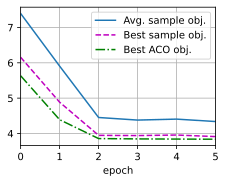

In [5]:
n_node, n_ants = 20, 20
k_sparse = 10
steps_per_epoch = 32
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Train heuristic and pheromone generator for TSP100: 

total training duration: 42.06313347816467
epoch -1: (21.38282272338867, 19.162642250061037, 18.147364730834962)
epoch 0: (16.310125846862793, 14.300131978988647, 12.48026577949524)
epoch 1: (10.85941185951233, 9.858359985351562, 8.884306135177612)
epoch 2: (9.724036617279053, 8.890785808563232, 8.519577207565307)
epoch 3: (9.673074369430543, 8.769356698989869, 8.419820947647095)
epoch 4: (9.495818872451782, 8.751130466461182, 8.387913842201232)


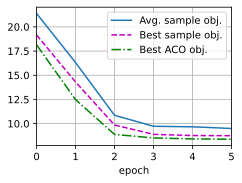

In [17]:
n_node = 100
n_ants = 50
k_sparse = 20
steps_per_epoch = 32
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Train heuristic and pheromone generator for TSP500: 

total training duration: 153.32039427757263
epoch -1: (69.11425750732423, 65.86431957244874, 64.54609096527099)
epoch 0: (56.26344680786133, 52.91917736053467, 48.694024085998535)
epoch 1: (24.507202587127686, 23.097904567718505, 20.367847385406495)
epoch 2: (21.72960889816284, 20.654843616485596, 19.655255680084228)
epoch 3: (21.3880873298645, 20.332503147125244, 19.472693157196044)
epoch 4: (21.26847101211548, 20.24222078323364, 19.285104637145995)


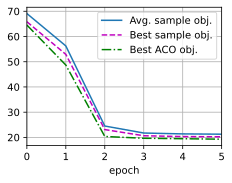

In [18]:
n_node = 500
n_ants = 50
k_sparse = 50
steps_per_epoch = 32
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)